# Load Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import ast
import os
import time
import joblib
import json
import csv
import pathlib
import librosa
import librosa.display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from pprint import pprint
%matplotlib inline

from functions.functions_features import extract_features

In [ ]:
# from tqdm import tqdm
# for i in tqdm(range(100)):
#     pass

100%|██████████| 100/100 [00:00<00:00, 1353001.29it/s]


# Load Functions

In [3]:
# Get columns
columns_features = [
    'mean', 'variance', 'std_dev', 'max_value', 'min_value', 'rms',
    'skewness', 'kurtosis', 'median', 'range_val', 'iqr',
    'zcr', 'energy', 'rmse', 'entropy',
    'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast',
    'spectral_flatness', 'spectral_rolloff', 'chroma_stft',
    ]

# MFCC
for i in range(1, 21):
    columns_features.append(f'mfcc_mean_{i}_mean')
    columns_features.append(f'mfcc_{i}_std')

# Details

In [4]:
# Get cough
list_dataset_name = [
    'coswara', 
    'coughvid', 
    'esc50', 
    'fsdkaggle', 
    'virufy',
    ]

overlap=0 # To avoid overfitting when doing kfold

if not os.path.exists(f'Results_Onset/Features/ML'):
    os.makedirs(f'Results_Onset/Features/ML')

# Extract ML features

In [5]:
for segment_length in [0.1, 0.2, 0.3, 0.5, 0.7, 1]:
    for dataset_name in list_dataset_name:
        print('\n', dataset_name, segment_length)
        
        df_all = pd.read_csv(f'Results_Onset/Data_Onset/Annotation/data_summary_{dataset_name}_{segment_length}s_onset_label.csv')
        # df_all = df_all[df_all['label']==1].reset_index(drop=True)
        df_all['label_onset'] = df_all['label_onset'].apply(ast.literal_eval)
        df_all['label_event'] = df_all['label_event'].apply(ast.literal_eval)
        df_all = df_all.sample(frac=1).groupby('label').head(1000).reset_index(drop=True)

        total_len = len(df_all)
        results_all = pd.DataFrame()
        path_save = f'Results_Onset/Features/ML/data_extracted_{dataset_name}_{segment_length}s_onset_label.csv'

        if os.path.exists(path_save) == False:
        
            for i in tqdm(range(total_len)):
        
                filepath = df_all['filepath'][i] # Audio path
                dataset = df_all['dataset'][i] # Dataset name
                filename = df_all['filename'][i]
                
                label = df_all['label'][i]
                age = df_all['age'][i]
                gender = df_all['gender'][i]
                status = df_all['status'][i]
                label_onset = df_all['label_onset'][i]
        
                (y, sr) = librosa.load(filepath) # mono=True
                duration = librosa.get_duration(y=y, sr=sr)
        
                segment_samples = int(segment_length * sr)
                step = segment_samples - int(overlap * sr)
        
                results = []
        
                # Set counter to only process the first 10 0 and 1
                counter = {0: 0, 1: 0}
                for j in range(0, len(label_onset)):
                    if counter[label_onset[j]] < 5:
                        start_sample = j * segment_samples
                        segment = y[start_sample:start_sample + segment_samples]
            
                        if len(segment) < segment_samples:
                            padding = np.zeros(segment_samples - len(segment))
                            segment = np.concatenate((segment, padding))

                        mean = np.mean(np.abs(segment))
                        
                        result_row = extract_features(segment, sr)
                        results.append([dataset, filename, filepath, label, age, gender, status, mean, label_onset[j]] + result_row)
                        counter[label_onset[j]] += 1
                
                columns = ['dataset', 'filename', 'filepath', 'label', 'age', 'gender', 'status', 'mean_amplitude', 'label_onset'] + columns_features
                results = pd.DataFrame(results, columns=columns)
                results_all = pd.concat([results_all, results])
            
            columns = ['dataset', 'filename', 'filepath', 'label', 'age', 'gender', 'status', 'mean_amplitude', 'label_onset'] + columns_features
            results_all = pd.DataFrame(results_all, columns=columns)
            results_all.to_csv(path_save, index=False)
            print(results_all.shape)

coswara 0.1
Counter({1: 1000, 0: 1000})


100%|██████████| 2000/2000 [02:52<00:00, 11.62it/s]


Len: 14589
(14589, 70)
coughvid 0.1
Counter({0: 1000, 1: 1000})


100%|██████████| 2000/2000 [04:00<00:00,  8.31it/s]


Len: 14967
(14967, 70)
esc50 0.1
Counter({0: 1000, 1: 40})


100%|██████████| 1040/1040 [01:30<00:00, 11.55it/s]


Len: 5400
(5400, 70)
fsdkaggle 0.1
Counter({0: 1000, 1: 273})


100%|██████████| 1273/1273 [02:07<00:00, 10.01it/s]


Len: 7403
(7403, 70)
virufy 0.1
Counter({1: 121})


100%|██████████| 121/121 [00:19<00:00,  6.29it/s]


Len: 1097
(1097, 70)
coswara 0.2
Counter({1: 1000, 0: 1000})


100%|██████████| 2000/2000 [06:26<00:00,  5.17it/s]


Len: 14507
(14507, 70)
coughvid 0.2
Counter({0: 1000, 1: 1000})


100%|██████████| 2000/2000 [15:11<00:00,  2.19it/s]


Len: 14874
(14874, 70)
esc50 0.2
Counter({0: 1000, 1: 40})


100%|██████████| 1040/1040 [06:31<00:00,  2.66it/s]


Len: 5389
(5389, 70)
fsdkaggle 0.2
Counter({0: 1000, 1: 273})


100%|██████████| 1273/1273 [08:53<00:00,  2.39it/s]


Len: 6955
(6955, 70)
virufy 0.2
Counter({1: 121})


100%|██████████| 121/121 [00:21<00:00,  5.52it/s]


Len: 897
(897, 70)
coswara 0.3
Counter({0: 1000, 1: 1000})


100%|██████████| 2000/2000 [08:04<00:00,  4.12it/s]


Len: 14293
(14293, 70)
coughvid 0.3
Counter({0: 1000, 1: 1000})


100%|██████████| 2000/2000 [08:38<00:00,  3.86it/s]


Len: 14554
(14554, 70)
esc50 0.3
Counter({0: 1000, 1: 40})


100%|██████████| 1040/1040 [03:09<00:00,  5.50it/s]


Len: 5371
(5371, 70)
fsdkaggle 0.3
Counter({0: 1000, 1: 273})


100%|██████████| 1273/1273 [03:57<00:00,  5.35it/s]


Len: 6498
(6498, 70)
virufy 0.3
Counter({1: 121})


100%|██████████| 121/121 [00:20<00:00,  5.88it/s]


Len: 726
(726, 70)
coswara 0.5
Counter({0: 1000, 1: 1000})


100%|██████████| 2000/2000 [08:24<00:00,  3.97it/s]


Len: 13308
(13308, 70)
coughvid 0.5
Counter({1: 1000, 0: 1000})


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Len: 13901
(13901, 70)
esc50 0.5
Counter({0: 1000, 1: 40})


100%|██████████| 1040/1040 [02:52<00:00,  6.03it/s]


Len: 5319
(5319, 70)
fsdkaggle 0.5
Counter({0: 1000, 1: 273})


100%|██████████| 1273/1273 [03:13<00:00,  6.58it/s]


Len: 5768
(5768, 70)
virufy 0.5
Counter({1: 121})


100%|██████████| 121/121 [00:14<00:00,  8.64it/s]


Len: 484
(484, 70)
coswara 0.7
Counter({0: 1000, 1: 1000})


100%|██████████| 2000/2000 [07:48<00:00,  4.27it/s]


Len: 12013
(12013, 70)
coughvid 0.7
Counter({0: 1000, 1: 1000})


100%|██████████| 2000/2000 [06:22<00:00,  5.23it/s]


Len: 13225
(13225, 70)
esc50 0.7
Counter({0: 1000, 1: 40})


100%|██████████| 1040/1040 [04:45<00:00,  3.64it/s]


Len: 5293
(5293, 70)
fsdkaggle 0.7
Counter({0: 1000, 1: 273})


100%|██████████| 1273/1273 [09:13<00:00,  2.30it/s]


Len: 5356
(5356, 70)
virufy 0.7
Counter({1: 121})


100%|██████████| 121/121 [00:24<00:00,  5.00it/s]


Len: 363
(363, 70)
coswara 1
Counter({0: 1000, 1: 1000})


100%|██████████| 2000/2000 [18:15<00:00,  1.83it/s]


Len: 10311
(10311, 70)
coughvid 1
Counter({1: 1000, 0: 1000})


100%|██████████| 2000/2000 [20:30<00:00,  1.63it/s]


Len: 12006
(12006, 70)
esc50 1
Counter({0: 1000, 1: 40})


100%|██████████| 1040/1040 [02:18<00:00,  7.53it/s]


Len: 5200
(5200, 70)
fsdkaggle 1
Counter({0: 1000, 1: 273})


100%|██████████| 1273/1273 [01:53<00:00, 11.21it/s]


Len: 4719
(4719, 70)
virufy 1
Counter({1: 121})


100%|██████████| 121/121 [00:04<00:00, 28.60it/s]

Len: 242
(242, 70)


# Plot histogram

Window length: 0.1
x_non_cough_non_audio: 19847
x_non_cough_cough_audio: 11768
x_cough_cough_audio: 11841


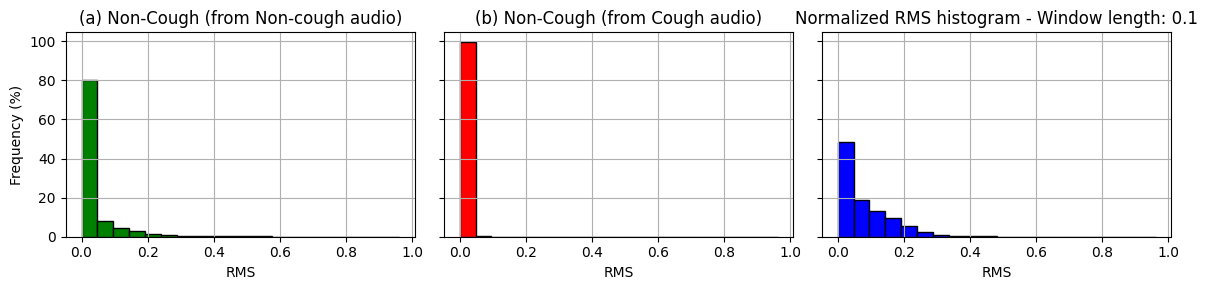

Window length: 0.2
x_non_cough_non_audio: 19680
x_non_cough_cough_audio: 11518
x_cough_cough_audio: 11424


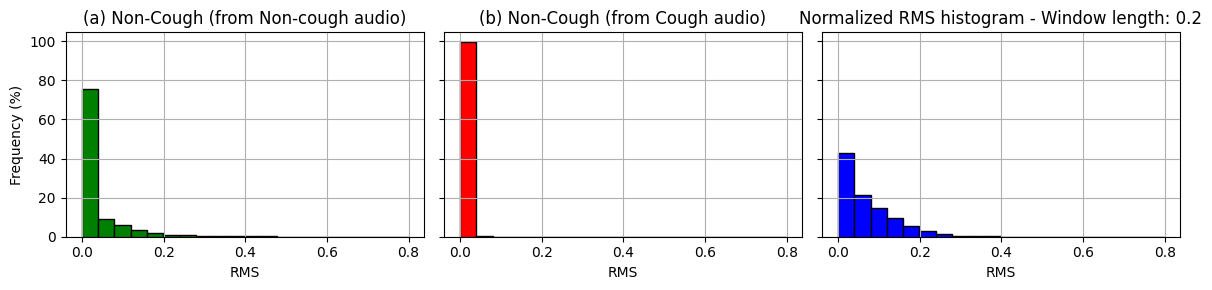

Window length: 0.3
x_non_cough_non_audio: 19404
x_non_cough_cough_audio: 11163
x_cough_cough_audio: 10875


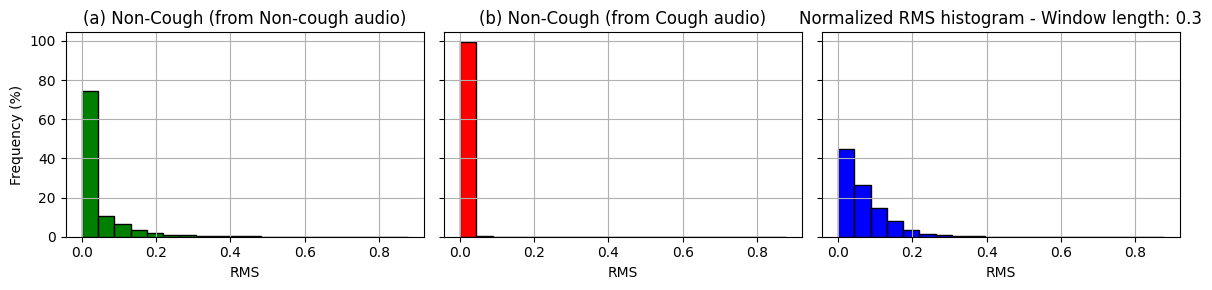

Window length: 0.5
x_non_cough_non_audio: 18850
x_non_cough_cough_audio: 10003
x_cough_cough_audio: 9927


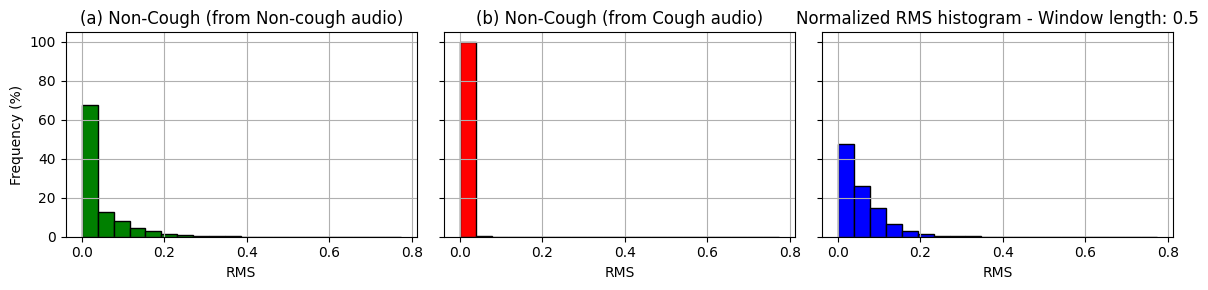

Window length: 0.7
x_non_cough_non_audio: 18527
x_non_cough_cough_audio: 8600
x_cough_cough_audio: 9123


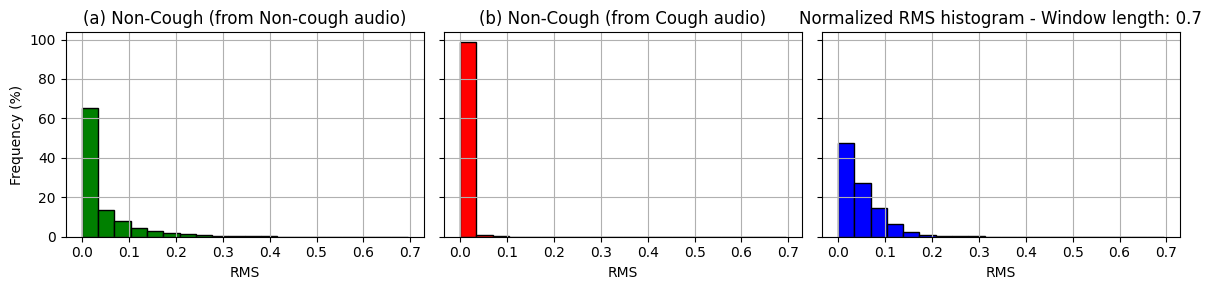

Window length: 1
x_non_cough_non_audio: 17990
x_non_cough_cough_audio: 6328
x_cough_cough_audio: 8160


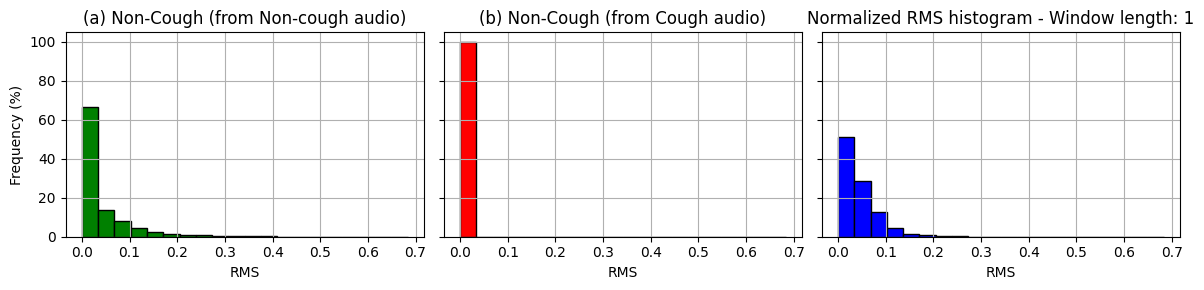

In [9]:
for segment_length in [0.1, 0.2, 0.3, 0.5, 0.7, 1]:
    print(f'Window length: {segment_length}')
    df_all = pd.DataFrame()
    for dataset_name in list_dataset_name:
        # print(dataset_name)
        df = pd.read_csv(f'Results_Onset/Features/ML/data_extracted_{dataset_name}_{segment_length}s_onset_label.csv')
        df_all = pd.concat([df_all, df])
    
    # Extract RMS values
    x_non_cough_non_audio = df_all[(df_all['label'] == 0) & (df_all['label_onset'] == 0)]['mean_amplitude'].tolist()
    x_non_cough_cough_audio = df_all[(df_all['label'] == 1) & (df_all['label_onset'] == 0)]['mean_amplitude'].tolist()
    x_cough_cough_audio = df_all[(df_all['label'] == 1) & (df_all['label_onset'] == 1)]['mean_amplitude'].tolist()
    
    print(f'x_non_cough_non_audio: {len(x_non_cough_non_audio)}')
    print(f'x_non_cough_cough_audio: {len(x_non_cough_cough_audio)}')
    print(f'x_cough_cough_audio: {len(x_cough_cough_audio)}')
    
    # Determine common bin edges
    all_rms_values = x_non_cough_non_audio + x_non_cough_cough_audio + x_cough_cough_audio
    _, bins = np.histogram(all_rms_values, bins=20)
    
    # Create 3 horizontal plots with shared x-axis
    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)
    
    axes[0].hist(x_non_cough_non_audio, bins=bins, color='green', edgecolor='black', 
                 weights=[100 / len(x_non_cough_non_audio)] * len(x_non_cough_non_audio))
    axes[0].set_title(f'(a) Non-Cough (from Non-cough audio)')
    axes[0].set_ylabel('Frequency (%)')
    
    axes[1].hist(x_non_cough_cough_audio, bins=bins, color='red', edgecolor='black', 
                 weights=[100 / len(x_non_cough_cough_audio)] * len(x_non_cough_cough_audio))
    axes[1].set_title(f'(b) Non-Cough (from Cough audio)')
    
    axes[2].hist(x_cough_cough_audio, bins=bins, color='blue', edgecolor='black', 
                 weights=[100 / len(x_cough_cough_audio)] * len(x_cough_cough_audio))
    axes[2].set_title(f'(c) Cough (from Cough audio)')
    
    for ax in axes:
        ax.set_xlabel('RMS')
        ax.grid(True)
        yticks = ax.get_yticks()

    plt.title(f'Normalized RMS histogram - Window length: {segment_length}')
    plt.tight_layout()
    plt.show()